In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from distribution import gini, gamma

In [17]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

class PotentialCriminal(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = model.wealth_arr[unique_id]
        self.criminal = False
        
    def step(self): 
        if self.criminal:  
            return

        other_agent = self.random.choice(self.model.schedule.agents)

        if other_agent.wealth * self.model.deterrence - self.wealth > 0:
            self.criminal = True

            stolen_amount = self.random.gauss(*self.model.fraction_stolen) * other_agent.wealth
            self.wealth += stolen_amount 
            other_agent.wealth -= stolen_amount
        
        return

def get_crime_rate(model):
    agent_out = [agent.criminal for agent in model.schedule.agents]
    return sum(agent_out)/model.num_agents

def get_gini(model):
    return gini(model.wealth_arr, plot=False)
    

class CrimeModel(Model):
    def __init__(self, N, deterrence, wealth_arr, fraction_stolen):
        self.num_agents = N
        self.deterrence = deterrence
        self.wealth_arr = wealth_arr
        self.fraction_stolen = fraction_stolen
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Crime rate": get_crime_rate,
                             "Gini Coefficient": get_gini
                             },
            agent_reporters={"Criminal": "criminal"}
        )
        
        for i in range(self.num_agents):
            a = PotentialCriminal(i, self)
            self.schedule.add(a)
    
    def crime_rate(self):
        return sum([a.criminal for a in self.schedule.agents])/self.num_agents
    
    def update_wealth_arr(self):
        self.wealth_arr = np.array([a.wealth for a in self.schedule.agents])
            
    def step(self):
        self.datacollector.collect(self)
        self.update_wealth_arr()
        self.schedule.step()

In [18]:
parameters = {
    "N": [100],
    "deterrence": [0.01, 0.1, 0.5],
    "gamma_alpha": [1, 2, 10],
    "gamma_beta": [1, 2, 10],
    "steps": [100],
    "distribution": ["gamma"],
    "fraction_stolen": [(0, 0.5)]
}
    

Combination 1/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 1, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 2/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 1, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 3/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 1, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 4/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 2, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 5/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 2, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 6/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 2, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 7/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 10, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 8/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 10, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 9/27 
Parameters: {'N': 100, 'deterrence': 0.01, 'gamma_alpha': 10, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 10/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 1, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 11/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 1, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 12/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 1, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 13/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 2, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 14/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 2, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 15/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 2, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 16/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 10, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 17/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 10, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 18/27 
Parameters: {'N': 100, 'deterrence': 0.1, 'gamma_alpha': 10, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 19/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 1, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 20/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 1, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 21/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 1, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 22/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 2, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 23/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 2, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 24/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 2, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 25/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 10, 'gamma_beta': 1, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 26/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 10, 'gamma_beta': 2, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


Combination 27/27 
Parameters: {'N': 100, 'deterrence': 0.5, 'gamma_alpha': 10, 'gamma_beta': 10, 'steps': 100, 'distribution': 'gamma', 'fraction_stolen': (0, 0.5)}


C:\Users\Nutzer\AppData\Local\Temp\ipykernel_7244\1821777908.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


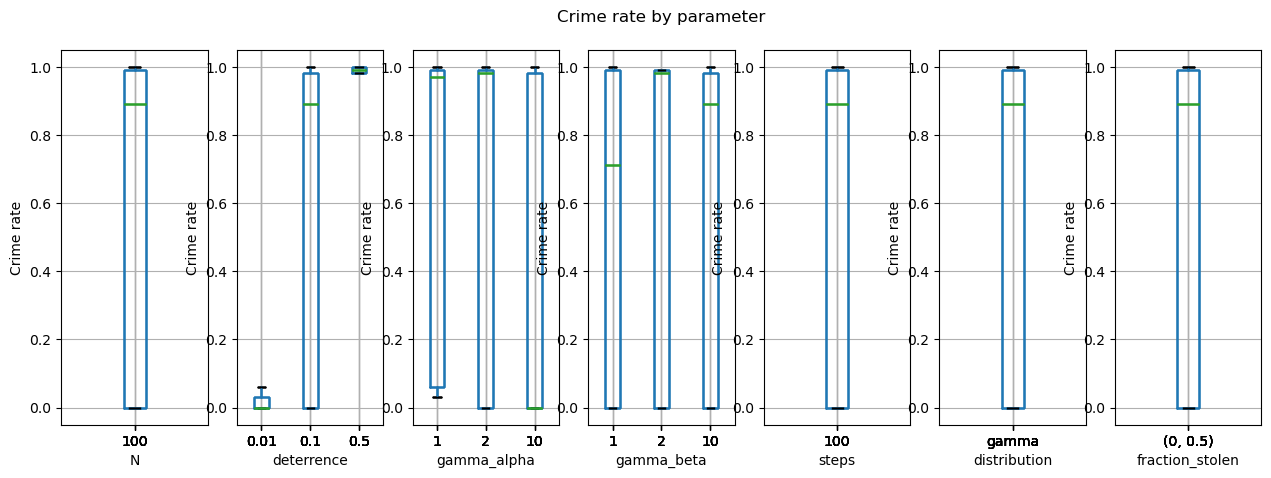

In [19]:
# create combinations of parameters
param_names = list(parameters.keys())
param_combinations = list(itertools.product(*[parameters[param] for param in param_names]))

results = []
counter = 0

for combination in param_combinations:  
    counter += 1
    print(f"Combination {counter}/{len(param_combinations)} \n"
            f"Parameters: {dict(zip(param_names, combination))}")
    # initialize parameters
    param_dict = dict(zip(param_names, combination))
    N = param_dict["N"]
    deterrence = param_dict["deterrence"]
    gamma_alpha = param_dict["gamma_alpha"]
    gamma_beta = param_dict["gamma_beta"]
    steps = param_dict["steps"]
    distribution = param_dict["distribution"]
    fraction_stolen = param_dict["fraction_stolen"]
    
    # create distribution
    wealth_arr = gamma(gamma_alpha, gamma_beta, N, plot=False)
    
    # create model
    model = CrimeModel(N, deterrence, wealth_arr, fraction_stolen)
    while model.schedule.steps < steps:
        model.step()
    
    # get data    
    model_df = model.datacollector.get_model_vars_dataframe()
    agent_df = model.datacollector.get_agent_vars_dataframe()
       
    # add data to results df
    results.append({
        "N": N,
        "deterrence": deterrence,
        "gamma_alpha": gamma_alpha,
        "gamma_beta": gamma_beta,
        "steps": steps,
        "distribution": distribution,
        "fraction_stolen": fraction_stolen,
        "gini_start": model_df['Gini Coefficient'].values[0],
        "gini_end": model_df['Gini Coefficient'].values[-1],
        "crime_rate": model_df['Crime rate'].values[-1],
        "wealth_arr_start": wealth_arr,
        "wealth_arr_end": model.wealth_arr,
        "gini_over_time": model_df['Gini Coefficient'].values.tolist(),  
        "crime_rate_over_time": model_df['Crime rate'].values.tolist()
    })
    
df_results = pd.DataFrame(results) 

fig, axs = plt.subplots(1, len(param_names), figsize=(15,5))
for param in param_names:
    for idx, param in enumerate(param_names):
        df_results.boxplot(column='crime_rate', by=param, ax=axs[idx])
        axs[idx].set_title('')
        axs[idx].set_xlabel(param)
        axs[idx].set_ylabel('Crime rate')
        
plt.suptitle('Crime rate by parameter')
plt.tight_layout
plt.show()

In [9]:
# df_sim1 = df_results
# df_sim1

In [10]:
df_sim2 = df_results
df_sim2

,N,deterrence,gamma_alpha,gamma_beta,steps,distribution,fraction_stolen,gini_start,gini_end,crime_rate,wealth_arr_start,wealth_arr_end,gini_over_time,crime_rate_over_time
0,100,0.01,1,1,100,gamma,"(0, 0.5)",0.536646,1.006927,1.00,"[2.1875226220322, 2.3037046711378535, 0.940563...","[0.3124743034936869, 0.870156342221798, 0.5147...","[0.5366457197080069, 0.5366457197080069, 0.738...","[0.0, 0.5, 0.77, 0.82, 0.87, 0.93, 0.93, 0.94,..."
1,100,0.01,1,2,100,gamma,"(0, 0.5)",0.488935,0.816907,0.98,"[1.3764046046502572, 0.6214706588545691, 0.518...","[0.6091286290243394, -2.1986088074578007, -0.7...","[0.48893517894909366, 0.48893517894909366, 0.6...","[0.0, 0.52, 0.71, 0.83, 0.87, 0.87, 0.9, 0.9, ..."
2,100,0.01,1,10,100,gamma,"(0, 0.5)",0.483815,1.307221,1.00,"[39.28288905168075, 19.687082320303052, 5.8070...","[-3.6349760958226742, -39.09647333512473, 12.1...","[0.48381499632427605, 0.48381499632427605, 0.7...","[0.0, 0.54, 0.69, 0.75, 0.77, 0.81, 0.88, 0.88..."
3,100,0.01,2,1,100,gamma,"(0, 0.5)",0.355126,1.294946,1.00,"[3.5580665602705204, 0.881584948891297, 2.5152...","[-0.6749273360957297, 1.8050781122352564, 0.54...","[0.35512568869218974, 0.35512568869218974, 0.8...","[0.0, 0.54, 0.65, 0.78, 0.86, 0.89, 0.92, 0.93..."
4,100,0.01,2,2,100,gamma,"(0, 0.5)",0.393998,0.685349,0.99,"[6.668223968186783, 1.8899735530380972, 7.4262...","[-1.3295053519450193, 2.2796557897676855, 7.99...","[0.3939981700325331, 0.3939981700325331, 0.530...","[0.0, 0.5, 0.7, 0.81, 0.84, 0.9, 0.92, 0.92, 0..."
5,100,0.01,2,10,100,gamma,"(0, 0.5)",0.415156,1.368612,0.99,"[19.03192141154006, 38.89971368555536, 41.2725...","[2.0872352543264534, -9.902194436164965, 4.242...","[0.41515555697227857, 0.41515555697227857, 0.6...","[0.0, 0.47, 0.68, 0.76, 0.8, 0.87, 0.9, 0.92, ..."
6,100,0.01,10,1,100,gamma,"(0, 0.5)",0.192149,0.679116,1.00,"[8.205763907648684, 5.979913406381345, 10.4588...","[8.052194965395323, 9.991948755779609, 5.56757...","[0.1921486294762259, 0.1921486294762259, 0.478...","[0.0, 0.55, 0.78, 0.84, 0.87, 0.92, 0.93, 0.94..."
7,100,0.01,10,2,100,gamma,"(0, 0.5)",0.156896,0.572757,1.00,"[20.60899646308775, 20.437344235982064, 28.560...","[14.592723793243927, 15.896743589962608, 46.59...","[0.15689617458382576, 0.15689617458382576, 0.3...","[0.0, 0.57, 0.79, 0.85, 0.91, 0.93, 0.94, 0.94..."
8,100,0.01,10,10,100,gamma,"(0, 0.5)",0.183598,1.008613,1.00,"[117.15087807480914, 87.06429869482173, 59.299...","[87.83662558042425, 46.070835967986135, 78.788...","[0.18359793174243977, 0.18359793174243977, 0.4...","[0.0, 0.56, 0.79, 0.87, 0.9, 0.93, 0.95, 0.96,..."
9,100,0.10,1,1,100,gamma,"(0, 0.5)",0.453226,0.790512,0.99,"[0.932403562722908, 0.6030362004620926, 0.2544...","[0.7946852188100506, 0.4577457546667438, 5.174...","[0.4532259074748417, 0.4532259074748417, 0.602...","[0.0, 0.51, 0.69, 0.81, 0.85, 0.88, 0.91, 0.92..."


In [11]:
def model_plots(df, idx):
    # Convert lists back to arrays
    gini_over_time = np.array(df.loc[idx, 'gini_over_time'])
    crime_rate_over_time = np.array(df.loc[idx, 'crime_rate_over_time'])
    wealth_arr_start = np.array(df.loc[idx, 'wealth_arr_start'])
    wealth_arr_end = np.array(df.loc[idx, 'wealth_arr_end'])

    fig, axs = plt.subplots(2,2, figsize=(10,10))
    axs[0,0].plot(gini_over_time)
    axs[0,0].set_title("Gini Coefficient over time")

    axs[0,1].plot(crime_rate_over_time)
    axs[0,1].set_title("Crime rate over time")

    axs[1,0].hist(wealth_arr_start, bins=50)
    axs[1,0].set_title(f"Wealth distribution start, Gini coefficient = {df.loc[idx, 'gini_start']:.2f}")

    axs[1,1].hist(wealth_arr_end, bins=50)
    axs[1,1].set_title(f"Wealth distribution end, Gini coefficient = {df.loc[idx, 'gini_end']:.2f}")
    
    fig.suptitle (f"N: N = {N} \n"
              f"deterrence = {deterrence} \n"
              f"gamma_alpha = {gamma_alpha}\n"
              f" gamma_beta = {gamma_beta}\n"
              f"steps = {steps}\n"
              f" distribution = {distribution}\n"
              f"fraction_stolen = {fraction_stolen}")
        
    plt.tight_layout()
    plt.show()

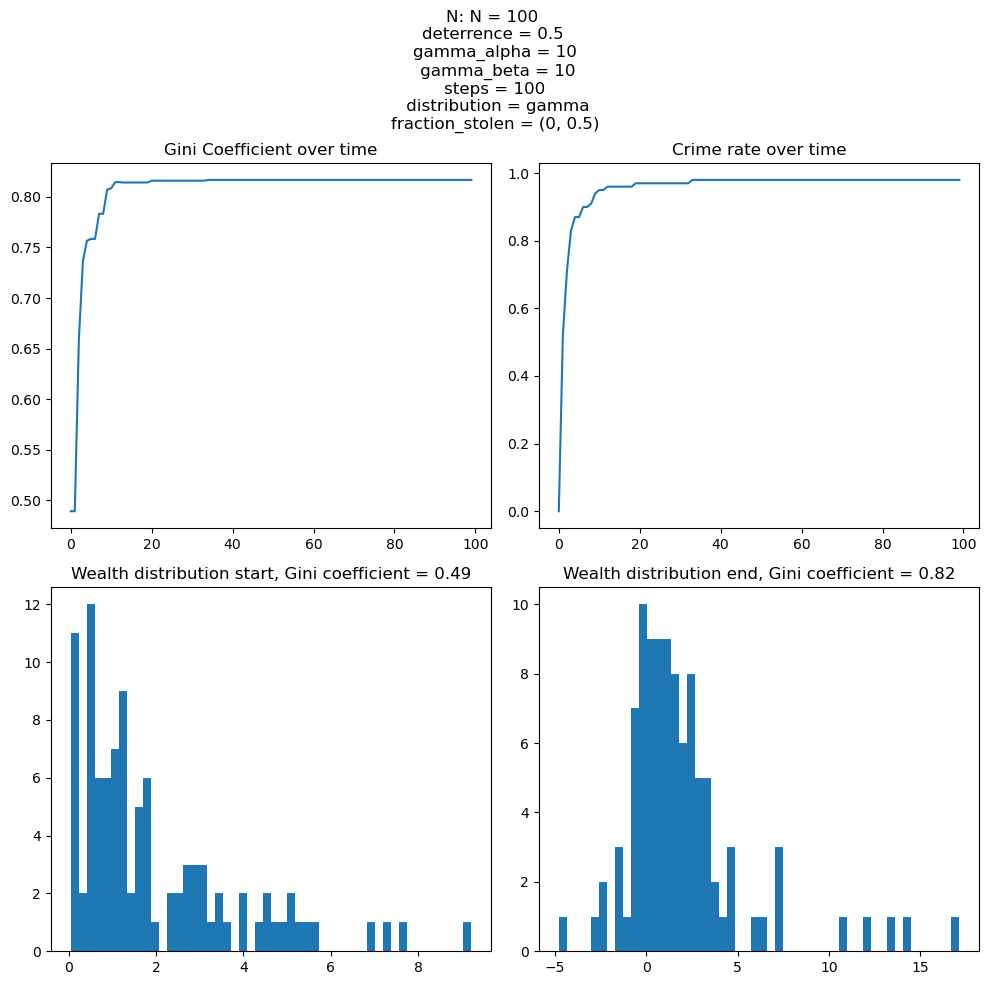

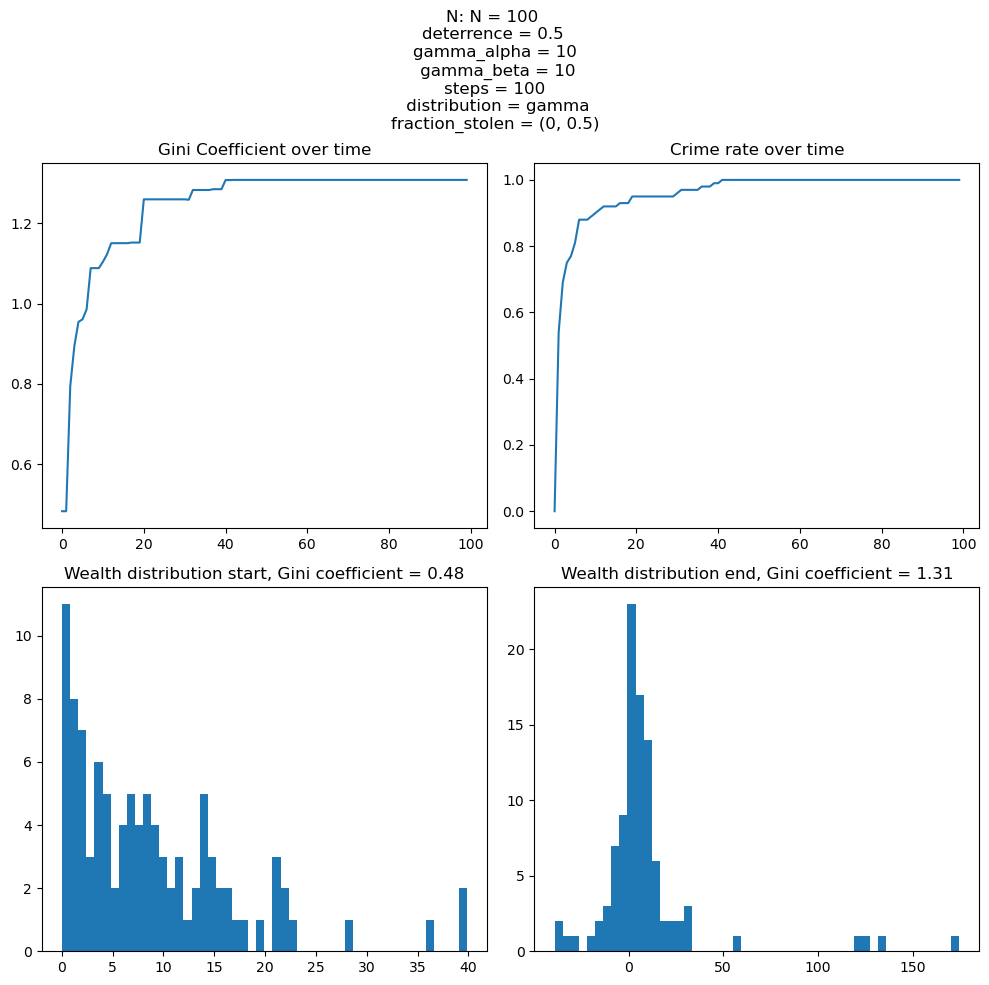

In [12]:
for idx in [1,2]:
    model_plots(df_sim2, idx)